In [64]:
!pip install wordcloud

In [65]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore")
import os


from sklearn.model_selection import train_test_split

In [66]:
df= pd.read_csv('df_combined_binary.csv')

In [67]:
dummy= pd.get_dummies(df["class"])

In [68]:
df_data=pd.concat((df['text'],dummy),axis=1)

In [69]:
df_data.dropna(inplace=True)
df_data.isna().sum().sum()

0

In [70]:
X=pd.DataFrame(df_data['text'])
y=pd.DataFrame(df_data.drop(['text'],axis=1))

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [72]:
X_cat=pd.DataFrame(df['text'])
y_cat=pd.DataFrame(df['class'])

# Split the data into train and test

In [73]:
Xcat_train, Xcat_test, ycat_train, ycat_test = train_test_split(X_cat, y_cat, test_size = 0.20, random_state = 0)

In [74]:
train= pd.concat((Xcat_train,ycat_train),axis=1)
test=pd.concat((Xcat_test,ycat_test),axis=1)

In [75]:
train.describe()

,text,class
count,11993,12000
unique,11992,4
top,white trash = white person procreating with a ...,not_hate
freq,2,5977


# EDA
## Distribution of classes

In [76]:
temp = train.groupby('class').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,class,text
2,not_hate,5970
1,implicit_hate,2027
0,explicit_hate,2009
3,offensive,1987


In [79]:
fig = go.Figure(go.Funnelarea(
    text =temp['class'],
    values = temp.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

## Number of words in text

In [82]:
train['Num_word_text'] = train['text'].apply(lambda x:len(str(x).split())) #Number Of words in main text
train.head()

,text,class,Num_word_text
13136,.@Arbys I’m a consumer too. I don’t jump on Tw...,not_hate,45
3536,let me know when you're ready to saddle up and...,implicit_hate,25
10296,@OldManRo you should check it out... it aint a...,not_hate,15
2137,"RT @Mitchellharri: Dont be a faggot, cover you...",explicit_hate,24
14775,MAGA -- consumer confidence pops in August to ...,not_hate,15


### Distribution of Number of words in the text

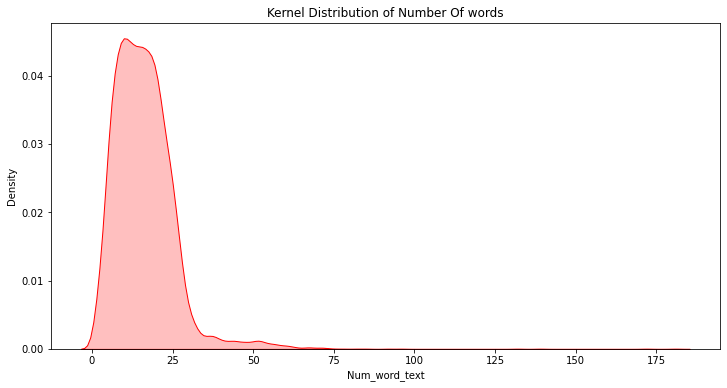

In [86]:
# Check distribtion of number of words 
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train['Num_word_text'], shade=True, color="r").set_title('Kernel Distribution of Number Of words')

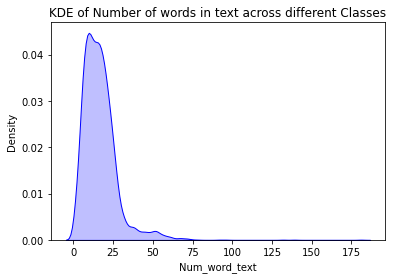

In [87]:
p1=sns.kdeplot(train[train['class']=='not_hate']['Num_word_text'], shade=True, color="b").set_title('KDE of Number of words in text across different Classes')


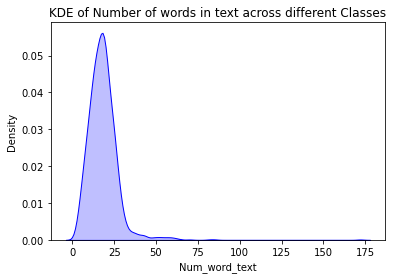

In [88]:
p1=sns.kdeplot(train[train['class']=='implicit_hate']['Num_word_text'], shade=True, color="b").set_title('KDE of Number of words in text across different Classes')


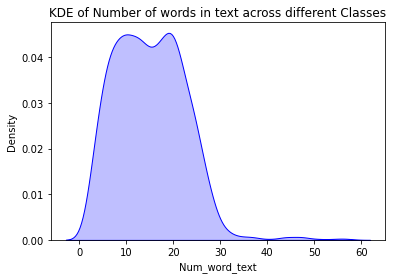

In [89]:
p1=sns.kdeplot(train[train['class']=='explicit_hate']['Num_word_text'], shade=True, color="b").set_title('KDE of Number of words in text across different Classes')


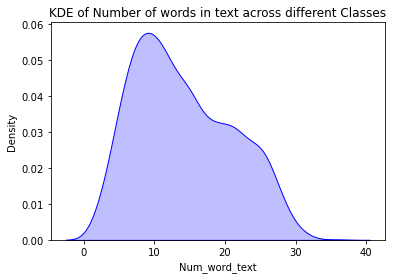

In [90]:
p1=sns.kdeplot(train[train['class']=='offensive']['Num_word_text'], shade=True, color="b").set_title('KDE of Number of words in text across different Classes')


### Distribution of Number of words per class

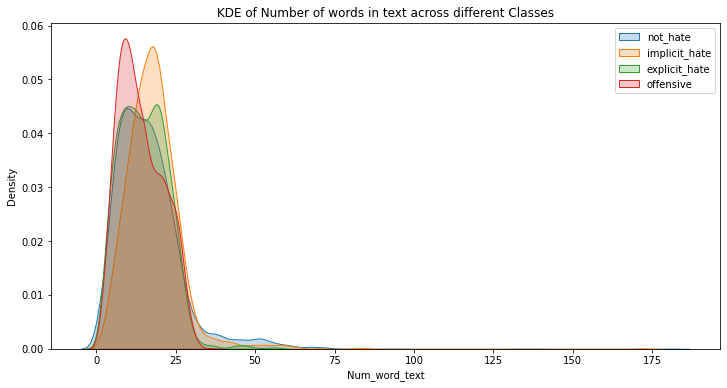

In [93]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train[train['class']=='not_hate']['Num_word_text'], shade=True).set_title('KDE of Number of words in text across different Classes')
p2=sns.kdeplot(train[train['class']=='implicit_hate']['Num_word_text'], shade=True)
p3=sns.kdeplot(train[train['class']=='explicit_hate']['Num_word_text'], shade=True)
p4=sns.kdeplot(train[train['class']=='offensive']['Num_word_text'], shade=True)
plt.legend(labels=['not_hate','implicit_hate','explicit_hate','offensive'])

Hence the number of words in the sentences are usually between 0- 50 , however only a small number of sentences contain number of words as high as 175
offensive -> number of words between 0 - 40 , with highest distribution of 10 words and comparatively lower dit. for 20 to 30 words
explicit hate -> number of words between 0 - 60 , with highest distribution between 0 to 30 words
implicit and not hate tend to contain high number of words in the text. Major portion of distribution however lies for word count less than 50 

# Clean the corpus

- Make text lowercase, 
- remove text in square brackets,
- remove links,
- punctuation
- remove words containing numbers.

In [94]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [95]:
train['text_clean'] = train['text'].apply(lambda x:clean_text(x))

In [96]:
train.head()

,text,class,Num_word_text,text_clean
13136,.@Arbys I’m a consumer too. I don’t jump on Tw...,not_hate,45,arbys i’m a consumer too i don’t jump on twitt...
3536,let me know when you're ready to saddle up and...,implicit_hate,25,let me know when youre ready to saddle up and ...
10296,@OldManRo you should check it out... it aint a...,not_hate,15,oldmanro you should check it out it aint anima...
2137,"RT @Mitchellharri: Dont be a faggot, cover you...",explicit_hate,24,rt mitchellharri dont be a faggot cover your m...
14775,MAGA -- consumer confidence pops in August to ...,not_hate,15,maga consumer confidence pops in august to hi...


## Find most common words in corpus